In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.data import Data
from models.combined_machine_learning import CombinedMachineLearning
from tqdm.notebook import tqdm
from wrap.stats import est_theta, exp_stats
from wrap.utils import train_test_split


p = 20
n = 200
rho = 0
theta = 100
lamb = 1

In [27]:
def run_experiments(theta, lambds, num_exp=10):
    df = pd.DataFrame()
    for lamb in tqdm(lambds):
        for i in range(num_exp):
            true_model = Data(p, rho, theta, lamb)
            y, d, x = true_model.generate(n)
            train, test = train_test_split(y, d, x)
            
            # Estimate l_hat + m_hat
            bbox = CombinedMachineLearning(true_model, train['x'].shape[1]+1, hidden_dims=(32, 32, 32),
                                      activation_params=dict(negative_slope=0.1))
            bbox.fit(train['x'], train['d'], train['y'])
            m_hat, l_hat = bbox.predict(test['x'], test['d'])
            
            # Statistics
            theta_hat, v2 = est_theta(test['y'], test['d'], m_hat, l_hat)
            dm_2, dl_2, dm_dl, bias = exp_stats(test['x'], m_hat, l_hat, theta, lamb)
            
            df_tmp = pd.DataFrame({
                'model' : ['mlp'],
                'rho' : rho,
                'lamb' : lamb,
                'theta' : theta,
                'theta.hat' : theta_hat,
                'dtheta' : theta_hat - theta,
                'bias' : bias/v2,
                'dm.2' : dm_2/v2,
                'dl.2' : dl_2/v2,
                'dm.dl' : dm_dl/v2,
            })
            df = pd.concat([df, df_tmp])
    
    return df

In [28]:
lambds = np.linspace(-0.5, 0.5, 11, endpoint=True)
df = run_experiments(theta, lambds, num_exp=100)
df_avg = df.groupby(['model', 'rho', 'lamb', 'theta']).mean().reset_index()

  0%|          | 0/11 [00:00<?, ?it/s]

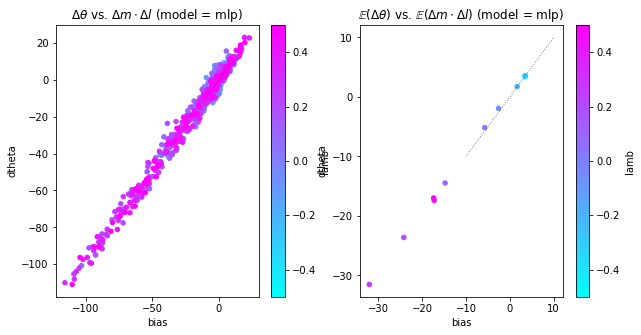

In [29]:
def plot_results(df, axs):
    df_tmp = df[df['model'] == 'mlp']
    df_tmp.plot.scatter(x='bias', y='dtheta', c='lamb', cmap=cm, ax=axs)
    axs.plot([-10, 10], [-10, 10], color='black', alpha=0.5, linewidth=1, linestyle=':')

cm = plt.cm.get_cmap('cool')
_, axs = plt.subplots(1, 2, figsize=(10, 5)) 

plot_results(df, axs[0])
axs[0].set_title('$\\Delta \\theta$ vs. $\\Delta m \cdot \\Delta l$ (model = mlp)')

plot_results(df_avg, axs[1])
axs[1].set_title('$\mathbb{E}(\\Delta \\theta$) vs. $\mathbb{E}(\\Delta m \cdot \\Delta l)$ (model = mlp)')

plt.savefig('results/combined_ml_bias_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()

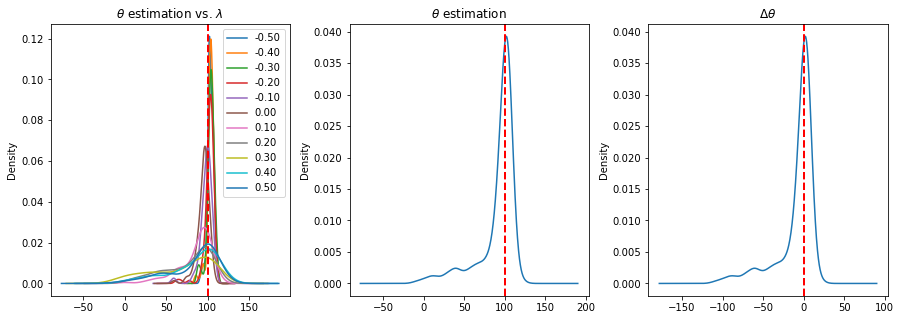

In [30]:
_, axs = plt.subplots(1, 3, figsize=(15, 5)) 
for lamb in lambds:
    df_tmp = df[df['lamb'] == lamb]
    df_tmp['theta.hat'].plot.kde(ax=axs[0], label='{:.2f}'.format(lamb))
axs[0].legend()
axs[0].axvline(x=theta, linestyle='--', linewidth=2., color='red')
axs[0].set_title('$\\theta$ estimation vs. $\lambda$')

df['theta.hat'].plot.kde(ax=axs[1])
axs[1].axvline(x=theta, linestyle='--', linewidth=2., color='red')
axs[1].set_title('$\\theta$ estimation')

df['dtheta'].plot.kde(ax=axs[2])
axs[2].axvline(x=0, linestyle='--', linewidth=2., color='red')
axs[2].set_title('$\\Delta \\theta$')

plt.subplots_adjust(wspace=0.25)
plt.savefig('results/combined_ml_theta_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()